In [7]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
train_data=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)
test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
    target_transform=None
)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=32, shuffle=False)

import torchvision.models as models
vgg16=models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
  param.requires_grad=False

vgg16.classifier=nn.Sequential(
  nn.Linear(in_features=25088,out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.5),
  nn.Linear(in_features=1024,out_features=512),
  nn.ReLU(),
  nn.Linear(in_features=512,out_features=10)
)

device="cuda" if torch.cuda.is_available() else "cpu"
vgg16=vgg16.to(device)


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(vgg16.classifier.parameters(),lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
torch.manual_seed(42)
epochs = 10

for epoch in range(epochs):
    train_loss, correct_train, total_train = 0.0, 0, 0
    vgg16.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = vgg16(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accuracy
        preds = torch.argmax(y_pred, dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)

        if batch % 400 == 0:
            print(f"Epoch: {epoch} | Batch: {batch} | Loss: {loss:.5f}")

    train_loss /= len(train_dataloader)
    train_acc = correct_train / total_train * 100

    # ---------------- Testing ----------------
    vgg16.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = vgg16(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            preds = torch.argmax(y_pred, dim=1)
            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

    test_loss /= len(test_dataloader)
    test_acc = correct_test / total_test * 100

    print(f"Epoch: {epoch} | "
          f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | "
          f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Batch: 0 | Loss: 2.30602
Epoch: 0 | Batch: 400 | Loss: 0.35542
Epoch: 0 | Batch: 800 | Loss: 0.16559
Epoch: 0 | Batch: 1200 | Loss: 0.44650
Epoch: 0 | Batch: 1600 | Loss: 0.13333
Epoch: 0 | Train loss: 0.36944, Train acc: 87.10% | Test loss: 0.28808, Test acc: 89.63%
Epoch: 1 | Batch: 0 | Loss: 0.15541
Epoch: 1 | Batch: 400 | Loss: 0.36194
Epoch: 1 | Batch: 800 | Loss: 0.14691
Epoch: 1 | Batch: 1200 | Loss: 0.50963
Epoch: 1 | Batch: 1600 | Loss: 0.40329
Epoch: 1 | Train loss: 0.27184, Train acc: 90.45% | Test loss: 0.25238, Test acc: 90.99%
Epoch: 2 | Batch: 0 | Loss: 0.30597
Epoch: 2 | Batch: 400 | Loss: 0.10873
Epoch: 2 | Batch: 800 | Loss: 0.36896
Epoch: 2 | Batch: 1200 | Loss: 0.37492
Epoch: 2 | Batch: 1600 | Loss: 0.13828
Epoch: 2 | Train loss: 0.23871, Train acc: 91.77% | Test loss: 0.24131, Test acc: 91.53%
Epoch: 3 | Batch: 0 | Loss: 0.09512
Epoch: 3 | Batch: 400 | Loss: 0.20667
Epoch: 3 | Batch: 800 | Loss: 0.17475
Epoch: 3 | Batch: 1200 | Loss: 0.02869
Epoch: 3 | B

In [10]:
# Save full model
torch.save(vgg16.state_dict(), "vgg16_fashionmnist.pth")
print("Model saved!")


Model saved!


In [11]:
# Create the same model architecture
import torchvision.models as models
from torch import nn

vgg16_loaded = models.vgg16(pretrained=True)
for param in vgg16_loaded.features.parameters():
    param.requires_grad = False

vgg16_loaded.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)

# Load saved weights
vgg16_loaded.load_state_dict(torch.load("vgg16_fashionmnist.pth", map_location=device))
vgg16_loaded = vgg16_loaded.to(device)
vgg16_loaded.eval()

print("Model loaded successfully!")



Model loaded successfully!


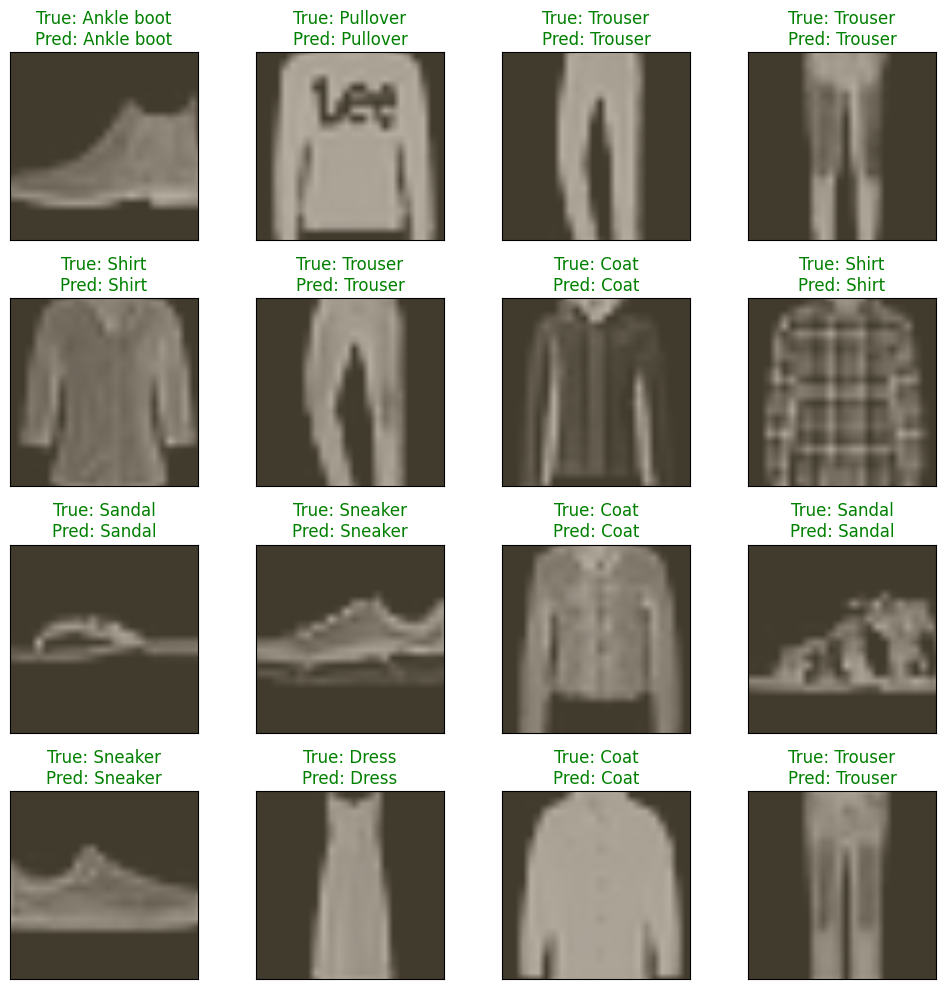

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Move images and labels to the device
images, labels = images.to(device), labels.to(device)

# Make predictions
vgg16.eval()
with torch.no_grad():
    outputs = vgg16(images)
    _, predicted = torch.max(outputs.data, 1)

# Convert images and labels to numpy for plotting
images = images.cpu().numpy()
labels = labels.cpu().numpy()
predicted = predicted.cpu().numpy()

# Define class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the images with true and predicted labels
fig = plt.figure(figsize=(10, 10))
for i in np.arange(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    # Unnormalize the image for display
    img = images[i].transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}',
                 color=("green" if predicted[i] == labels[i] else "red"))
plt.tight_layout()
plt.show()